# [SETI Breakthrough Listen - E.T. Signal Search](https://www.kaggle.com/c/seti-breakthrough-listen)
>Find extraterrestrial signals in data from deep space 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/23652/logos/header.png?t=2021-02-24-19-15-30)

# Version Info
* `v9` : moved from **StratifiedKFold** to **KFold** as those folder(groups) don't have any signifance.

# Notebook for Dataset
* [SETI-BL: 256x256 tfrec Data](https://www.kaggle.com/awsaf49/seti-bl-256x256-tfrec-data)

# Datasets
* [128x128](https://www.kaggle.com/awsaf49/setibl-128x128-tfrec-dataset)
* [256x256](https://www.kaggle.com/awsaf49/setibl-256x256-tfrec-dataset)
* [384x384](https://www.kaggle.com/awsaf49/setibl-384x384-tfrec-dataset)

# Initialize Environment

In [1]:
!pip install -q efficientnet >> /dev/null

In [2]:
import pandas as pd, numpy as np, random,os, shutil
from glob import glob
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
print('tf:',tf.__version__)

tf: 2.4.1


# Configuration

In [155]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE      = 1
DISPLAY_PLOT = True

DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 2, 5, 10
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 512 
IMG_SIZES = [256]*FOLDS


# BATCH SIZE AND EPOCHS
BATCH_SIZES = [64]*FOLDS
EPOCHS      = [13]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6]*FOLDS

# Augmentations
ROT_    = 0.0
SHR_    = 2.0
HZOOM_  = 8.0
WZOOM_  = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

# Dropout
PROBABILITY = 0.90
CT          = 16
SZ          = 0.08

#bri, contrast
sat  = (0.7, 1.3)
cont = (0.8, 1.2)
bri  =  0.1

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

# Reproducibility
Not very helpful for **TPU** 

In [4]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(SEED)

seeding done!!!


# TPU Configs

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Step 1: Preprocess
**NOTE:**
* Original Signal had **6** channels. I only took **3** as it was mention here,
```
Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels 1, 3, and 5 in the cadence snippets).
```
*  Didn't do any **Signal Processing** so far. Left it for the model.
*  Used simple augmentations, some of them may hurt the model.

In [6]:
GCS_PATH = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('setibl-%ix%i-tfrec-dataset'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))
num_train_files = len(files_train)
num_test_files  = len(files_test)
print('train_files:',num_train_files)
print('test_files:',num_test_files)

train_files: 20
test_files: 10


## Light EDA

In [7]:
# train_label_df = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
# test_label_df  = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

# train_paths = glob('../input/seti-breakthrough-listen/train/**/*.npy')
# test_paths = glob('../input/seti-breakthrough-listen/test/**/*.npy')

# train_df = pd.DataFrame({'filepath':train_paths})
# train_df['id'] = train_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
# train_df['group'] = train_df.filepath.map(lambda x: x.split('/')[-2])
# train_df = pd.merge(train_df, train_label_df, on='id', how='left')

# print(f'num_train: {len(train_paths)}\nnum_test : {len(test_paths)}')

# Class Distribution
**Tfrecord** dataset has total **20** files and for proper validatoin scheme, each has been made stratifing `target` & `group` feature. 

In [8]:
# from plotly.offline import init_notebook_mode, iplot, plot
# import plotly as py
# import plotly.express as px
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go

# fig = go.Figure(data=[
#     go.Bar(name='haystack', 
#            y=train_df.target.value_counts().values[0:1],
#            x=['haystack'],
#            text = train_df.target.value_counts()[0:1],
#            orientation='v',
#            textposition='outside',),
#     go.Bar(name='needle', 
#            y=train_df.target.value_counts().values[1:],
#            x=['needle'],
#            text = train_df.target.value_counts()[1:],
#            orientation='v',
#            textposition='outside',)
# ])
# # Change the bar mode
# fig.update_layout(
#                   width=800,
#                   height=600,
#                   title=f'Class Distribution',
#                   yaxis_title='Number of Images',
#                   xaxis_title='Class Name',)
# iplot(fig)

# Step 2: Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

As this is not typical **image** data rather **signal** typical augmantation for **image** may do some damage

In [9]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

## Dropout
check this [notebook](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169721) by chris for more explanation on **Coarse Dropout and Cutout**

![](https://lh3.googleusercontent.com/proxy/N5fzEAZQZMeyO6Tbn7aHjVfMoUywxJe80DlEts4DrkuR0YEpTYqB0Olzop4N2_t336a3PSdzkB3EEcZ5vb0kzd4O0cw)

Coarse Dropout and Cutout augmentation are techniques to prevent **overfitting** and encourage generalization. They randomly remove rectangles from training images. By removing portions of the images, we challenge our models to pay attention to the entire image because it never knows what part of the image will be present. (This is similar and different to dropout layer within a **CNN**).

* Cutout is the technique of removing 1 large rectangle of random size
* Coarse dropout is the technique of removing many small rectanges of similar size.

By changing the parameters below, we can have either coarse dropout or cutout. (For cutout, you'll need to add tf.random.uniform for random size. I leave this as an exercise for the reader.

In [187]:
def dropout(image,DIM=IMG_SIZES[0], PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM*3),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM*3,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM*3,:,:]],axis=0) 

    image = tf.reshape(image,[DIM*3,DIM,3])
    return image

## Reading TFRecord Data

In [188]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_id):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_id'] if return_image_id else 0

 
def prepare_image(img, augment=True, dim=IMG_SIZES[0]):    
    img = tf.image.decode_png(img, channels=3)
#     img = tf.transpose(img, perm=[2, 1, 0])
#     img = tf.experimental.numpy.vstack(img)
#     img = tf.stack([img for _ in range(3)], axis=-1)
    img = tf.concat([img[...,idx] for idx in range(3)], axis=0)
    img = tf.stack([img for _ in range(3)], axis=-1)
    img = tf.reshape(img, [dim*3,dim, 3])
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
#         img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, sat[0], sat[1])
        img = tf.image.random_contrast(img, cont[0], cont[1])
        img = tf.image.random_brightness(img, bri)     
                      
    img = tf.reshape(img, [dim*3,dim, 3])
            
    return img

def count_data_items(fileids):
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) 
         for fileid in fileids]
    return np.sum(n)

## Data Pipeline

In [191]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_ids=True, batch_size=16, dim=IMG_SIZES[0]):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2, seed=SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgid_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgid_or_label), 
                num_parallel_calls=AUTO)
    if labeled and augment:
        ds = ds.map(lambda img, label: (dropout(img, DIM=dim, PROBABILITY = 1.0, CT = CT, SZ = SZ), label),
                    num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization

In [166]:
def display_batch(batch, size=3):
    imgs, tars = batch
    idx=0
    for img_idx in range(size):
        idx+=1
        plt.figure(figsize=(5*2, 15*2))
        plt.subplot(size, 1, idx)
        plt.title(f'id:{tars[img_idx].numpy().decode("utf-8")}')
        plt.imshow(imgs[img_idx,:, :, 0].numpy().transpose(1, 0))
        plt.text(5, 15, str(idx), bbox={'facecolor': 'white'})
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show() 

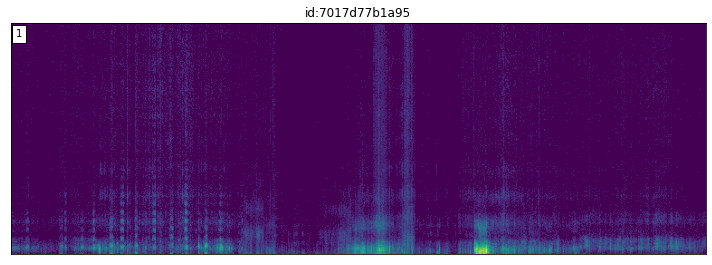

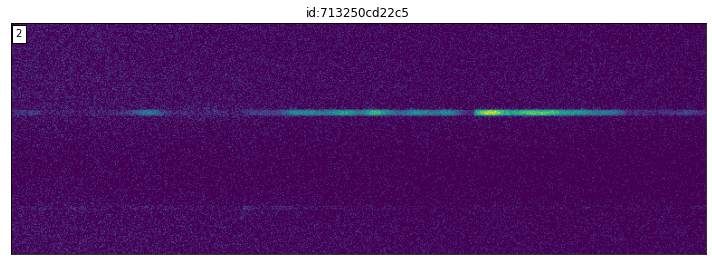

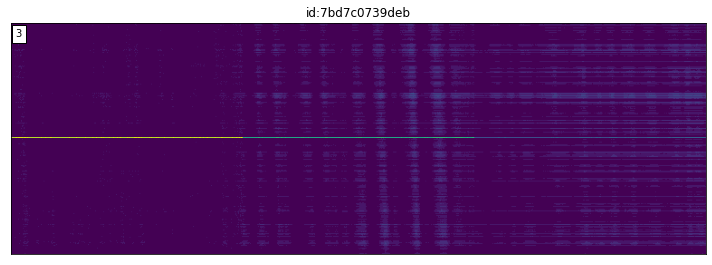

In [167]:
fold = 0
ds = get_dataset(files_train, augment=True, shuffle=True, repeat=True,labeled=False,return_image_ids=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold])
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 3);

In [ ]:
# plt.figure(figsize=(18, 6));
# plt.imshow(np.hstack(tf.transpose(img[0], perm=[2, 1, 0]).numpy()))

In [ ]:
# plt.figure(figsize=(6, 6*3))
# plt.imshow(tf.transpose(img[0], perm=[0, 2, 1]).numpy().reshape(-1,256))

# Step 3: Build Model
>Though there have been some amazing development, **EFficientNet** always come up with a decent score.

![EffNet](https://1.bp.blogspot.com/-MQO5qKuTT8c/XpdE8_IwpsI/AAAAAAAAFtg/mSjhF2ws5FYxwcHN6h9_l5DqYzQlNYJwwCLcBGAsYHQ/s1600/image1.png)

You can try other models like, 
* Vision Transformer (ViT)
* ResNet
* InceptionNet
* XceptionNet

Unfortunately, I couldn't find any completed implementation of **NF-Net**, so couldn't include it here.

In [173]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=None, ef=0):
    inp = tf.keras.layers.Input(shape=(dim*3,dim,3))
    base = EFNS[ef](input_shape=(dim*3,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

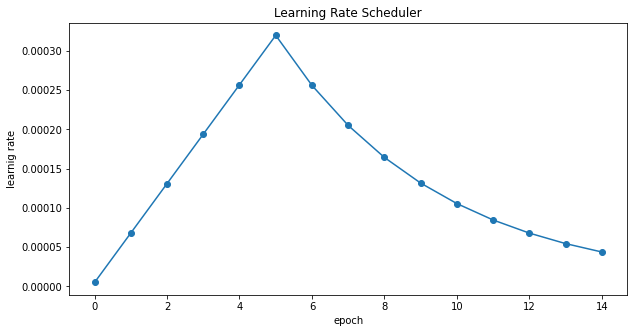

In [169]:
def get_lr_callback(batch_size=8, plot=False):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(EPOCHS[0]), [lrfn(epoch) for epoch in np.arange(EPOCHS[0])], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(BATCH_SIZES[0], plot=True )

## Train Model
* Our model will be trained for the number of `FOLDS` and `EPOCHS` you chose in the configuration above. Each fold the model with lowest validation `AUC` will be saved and used to predict OOF and test. 
* Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [ ]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_f1 = []; oof_ids = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(num_train_files))):
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    np.random.shuffle(files_train);
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size: %i | model: %s | batch_size %i'%
          (IMG_SIZES[fold],EFNS[EFF_NETS[fold]].__name__,BATCH_SIZES[fold]*REPLICAS))
    train_images = count_data_items(files_train)
    val_images   = count_data_items(files_valid)
    print('#### Training: %i | Validation: %i'%(train_images, val_images))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
    print('#'*25)   
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], 
        callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), 
        #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    # Loading best model for inference
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)  
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_ids=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND idS
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_ids=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_ids=True)
    oof_ids.append( np.array([img_id.numpy().decode("utf-8") for img, img_id in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_ids=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(history.history['auc'])),history.history['auc'],'-o',label='Train auc',color='#ff7f0e')
        plt.plot(np.arange(len(history.history['auc'])),history.history['val_auc'],'-o',label='Val auc',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('auc',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(len(history.history['auc'])),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(len(history.history['auc'])),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, %s'%
                (fold+1,IMG_SIZES[fold],EFNS[EFF_NETS[fold]].__name__),size=18)
        plt.legend(loc=3)
        plt.savefig(f'fig{fold}.png')
        plt.show()

#########################
#### FOLD 1
#### Image Size: 256 | model: EfficientNetB6 | batch_size 256
#### Training: 40131 | Validation: 10034
#########################
Training...
Epoch 1/15
156/156 [==============================] - 365s 1s/step - loss: 0.6085 - auc: 0.4976 - val_loss: 0.5038 - val_auc: 0.5428
Epoch 2/15
156/156 [==============================] - 184s 1s/step - loss: 0.3342 - auc: 0.5571 - val_loss: 0.2471 - val_auc: 0.8170
Epoch 3/15
156/156 [==============================] - 185s 1s/step - loss: 0.2115 - auc: 0.8656 - val_loss: 0.1972 - val_auc: 0.9179
Epoch 4/15
156/156 [==============================] - 184s 1s/step - loss: 0.1578 - auc: 0.9254 - val_loss: 0.1400 - val_auc: 0.9399
Epoch 5/15
156/156 [==============================] - 184s 1s/step - loss: 0.1339 - auc: 0.9408 - val_loss: 0.1240 - val_auc: 0.9539
Epoch 6/15
156/156 [==============================] - 184s 1s/step - loss: 0.1208 - auc: 0.9513 - val_loss: 0.1231 - val_auc: 0.9582
Epoch 7/15
156/156 [===

## Calculate OOF AUC
The **OOF** (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the **OOF** to determine what are the best weights to blend your models with. Choose weights that maximize **OOF** `CV` score when used to blend **OOF**. Then use those same weights to blend your test predictions.

**Remember**,
* Don't do blending just to climb **LB**, because most of the time it ends up getting overfitted.
* Try improving the **CV** by blending different model and you can keep an eye on the **LB**.
* As only`20%` data will be used for calculating **LB** score, relying on **CV** should be a safe option

In [ ]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_id = ids, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

# Step 5: Post process
There are ways to modify predictions based on patient information to increase **CV**-**LB**. You can experiment with that here on your **OOF**.

# Submit To Kaggle

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_ids=True)

image_ids = np.array([img_id.numpy().decode("utf-8") 
                        for img, img_id in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame({'id':image_ids, 'target':preds[:,0]})
submission = submission.sort_values('id') 
submission.to_csv('submission.csv', index=False)
submission.head()

# Prediction Distribution

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(submission.target,bins=100);

# Reference
* Please Check this amazing notebook, [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords) by [Chris Deotte](https://www.kaggle.com/cdeotte)


# Please **Upvote** if you find this helpful 👽